# Simple VQE Coding Exercise: H2 Molecule

This notebook guides you through a simplified VQE workflow to find the ground state energy of the Hydrogen molecule (H2). We will use the latest Qiskit 1.x features and the Qiskit Runtime primitives.

**Setup:**
You will need `qiskit`, `qiskit-ibm-runtime`, `numpy`, and `scipy`.
*(We will assume the Hamiltonian is given to simplify the chemistry part)*

`pip install qiskit qiskit-ibm-runtime numpy scipy`

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from scipy.optimize import minimize

--- 

## Task 1: Define the Hamiltonian

Instead of calculating the Hamiltonian from scratch using chemistry drivers (which can be complex), we will use a pre-calculated Hamiltonian for the H2 molecule at equilibrium distance (0.735 Angstroms).

The Hamiltonian is a sum of Pauli terms (like `II`, `IZ`, `XX`, etc.).

**Your Task:** Run the cell below to create the `SparsePauliOp` that represents our system's energy.

In [2]:
# Hamiltonian for H2 at 0.735 Angstroms (mapped to 2 qubits)
hamiltonian = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

print("H2 Hamiltonian:")
print(hamiltonian)

H2 Hamiltonian:
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


--- 

## Task 2: Create the Ansatz

We need a parameterized quantum circuit (Ansatz) to guess the ground state.

**Your Task:** Create an `EfficientSU2` circuit for 2 qubits. Use `linear` entanglement and 1 repetition (`reps=1`).

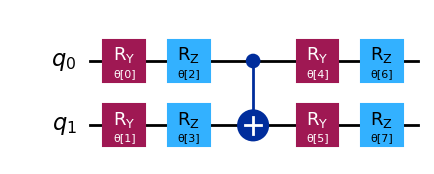

In [3]:
# --- Your Code Here ---
ansatz = EfficientSU2(num_qubits=2, entanglement="linear", reps=1)
# ----------------------

ansatz.decompose().draw("mpl")

--- 

## Task 3: Transpile for Backend

We will use a fake backend (`FakeManilaV2`) to simulate a real device. We must transpile our circuit and Hamiltonian to match this device.

**Your Task:** Use `generate_preset_pass_manager` to optimize the ansatz. Then map the Hamiltonian to the circuit's layout.

In [4]:
backend = FakeManilaV2()

# 1. Create Pass Manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# 2. Transpile Ansatz
ansatz_isa = pm.run(ansatz)

# 3. Apply Layout to Hamiltonian
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

print("Transpilation Complete!")

Transpilation Complete!


--- 

## Task 4: Define the Cost Function

The optimizer needs a function that takes parameters (`params`) and returns the Energy.

**Your Task:** Fill in the missing line to calculate the energy using the `estimator`.

In [5]:
estimator = Estimator(backend=backend)

def cost_func(params):
    # Create a PUB (Primitive Unified Bloc)
    pub = (ansatz_isa, hamiltonian_isa, params)
    
    # --- Your Code Here ---
    # Run the estimator and extract the result
    job = estimator.run([pub])
    result = job.result()[0]
    energy = result.data.evs
    # ----------------------
    
    return energy

print("Cost function defined.")

Cost function defined.


--- 

## Task 5: Run VQE

Now we use the classical optimizer `minimize` (from SciPy) to find the minimum energy.

**Your Task:** Run the cell to start the VQE loop.

In [6]:
# Initial random parameters
num_params = ansatz_isa.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

print(f"Starting VQE with {num_params} parameters...")

# Run optimization
result = minimize(cost_func, x0, method="COBYLA", options={"maxiter": 50})

print("\nOptimization Complete!")
print(f"Minimum Energy Found: {result.fun:.5f} Hartrees")
print(f"Target Energy (approx): -1.86 Hartrees")

Starting VQE with 8 parameters...

Optimization Complete!
Minimum Energy Found: -1.81735 Hartrees
Target Energy (approx): -1.86 Hartrees
